# Read data

In [356]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

import optuna

In [431]:
data_train = np.load('X_train.npy')
data_test = np.load('X_test.npy')

data_y_train = pd.read_csv('y_train.csv')
#y_test = pd.read_csv('y_test.csv')
data_y_test = pd.read_csv('sample_submission.csv')

print(data_train.shape, data_y_train.shape)
print(data_test.shape)

(323, 40, 100) (32300, 2)
(54, 40, 100)


## Представление целевой переменной

### Kaggle-удобный вид

In [433]:
print(data_y_train.shape)
data_y_train

(32300, 2)


,sample-timestep,class
0,0-0,0
1,0-1,0
2,0-2,0
3,0-3,0
4,0-4,0
...,...,...
32295,322-95,4
32296,322-96,4
32297,322-97,4
32298,322-98,4


### Исходный вид

In [434]:
data_y_train[['sample_id', 'timestep']] = data_y_train['sample-timestep'].str.split('-', 1, expand=True).astype(int)
data_y_train = data_y_train.pivot(index='sample_id', columns='timestep', values='class')
data_y_train_index = data_y_train.index
data_y_train = data_y_train.sort_index() # на всякий случай
data_y_train = data_y_train.values

print(data_y_train.shape)
data_y_train

(323, 100)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 6, 6, 6],
       ...,
       [0, 0, 0, ..., 7, 7, 7],
       [7, 7, 7, ..., 0, 0, 0],
       [0, 0, 0, ..., 4, 4, 4]], dtype=int64)

In [435]:
data_y_test[['sample_id', 'timestep']] = data_y_test['sample-timestep'].str.split('-', 1, expand=True).astype(int)
data_y_test = data_y_test.pivot(index='sample_id', columns='timestep', values='class')
data_y_test_index = data_y_test.index
data_y_test = data_y_test.sort_index() # на всякий случай
data_y_test = data_y_test.values

print(data_y_test.shape)
data_y_test

(54, 100)


array([[4, 4, 4, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 7, 7, 7],
       [7, 7, 7, ..., 0, 0, 0],
       [0, 0, 0, ..., 4, 4, 4]], dtype=int64)

### Переход от исходного вида к kaggle
Потенциально пригодится для формирования `y_test.csv`

In [436]:
df_y_train = []
for idx, arr in zip(data_y_train_index, data_y_train):
    
    series = pd.Series(arr)
    series.index = [f"{idx}-{i}" for i in series.index]
    df_y_train.append(series)
    
df_y_train = pd.concat(df_y_train)
df_y_train = df_y_train.reset_index()
df_y_train.columns = ["sample-timestep", "class"]
df_y_train

,sample-timestep,class
0,0-0,0
1,0-1,0
2,0-2,0
3,0-3,0
4,0-4,0
...,...,...
32295,322-95,4
32296,322-96,4
32297,322-97,4
32298,322-98,4


In [437]:
df_y_test = []
for idx, arr in zip(data_y_test_index, data_y_test):
    
    series = pd.Series(arr)
    series.index = [f"{idx}-{i}" for i in series.index]
    df_y_test.append(series)
    
df_y_test = pd.concat(df_y_test)
df_y_test = df_y_test.reset_index()
df_y_test.columns = ["sample-timestep", "class"]
df_y_test

,sample-timestep,class
0,323-0,4
1,323-1,4
2,323-2,4
3,323-3,4
4,323-4,4
...,...,...
5395,376-95,4
5396,376-96,4
5397,376-97,4
5398,376-98,4


## Объяснение данных

### Train

In [400]:
data_train.shape, data_y_train.shape

((323, 40, 100), (323, 100))

`y_train.csv` содержит следующие классы: 
  - `0` - команда "Open";
  - `1` - команда "сгиб мизинца";
  - `2` - команда "сгиб безымянного пальца";
  - `3` - команда "сгиб среднего пальца";
  - `4` - команда "жест пистолет";
  - `5` - команда "сгиб указательного пальца";
  - `6` - команда "сгиб большога пальца";
  - `7` - команда "жест ОК";
  - `8` - команда "жест grab";¶

In [458]:
data_train.shape

(323, 40, 100)

In [459]:
data_y_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 6, 6, 6],
       ...,
       [0, 0, 0, ..., 7, 7, 7],
       [7, 7, 7, ..., 0, 0, 0],
       [0, 0, 0, ..., 4, 4, 4]], dtype=int64)

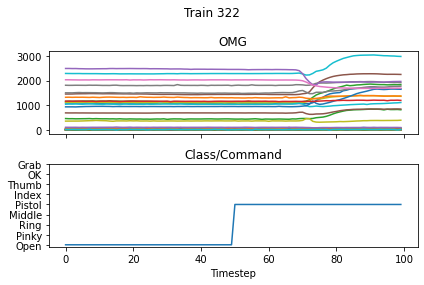

In [456]:
#i = np.random.randint(data_y_train.shape[0])
i = 322
fig, axx = plt.subplots(2, 1, sharex=True)
    
axx[0].plot(data_train[i].T)
axx[0].set_title('OMG')

axx[1].plot(data_y_train[i])
axx[1].set_title('Class/Command')
axx[1].set_xlabel('Timestep')
axx[1].set_yticks(
    np.arange(9),
    ['Open', 'Pinky', 'Ring', 'Middle', 'Pistol', 'Index', 'Thumb', 'OK', 'Grab']
)

plt.suptitle(f'Train {i}')

plt.tight_layout()

### Test

Как видно из визуализации, для теста нет целевой переменной.

Это и есть задача хакатона - предсказать, **какая команда была выполнена пользователем и в какое время**.

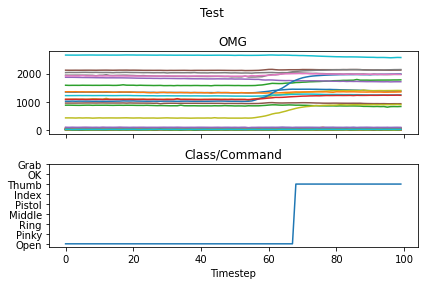

In [404]:
i = np.random.randint(data_y_test.shape[0])
fig, axx = plt.subplots(2, 1, sharex=True)
    
axx[0].plot(data_test[i].T)
axx[0].set_title('OMG')

axx[1].plot(data_y_test[i])

axx[1].set_title('Class/Command')
axx[1].set_xlabel('Timestep')
axx[1].set_yticks(
    np.arange(9),
    ['Open', 'Pinky', 'Ring', 'Middle', 'Pistol', 'Index', 'Thumb', 'OK', 'Grab']
)

plt.suptitle(f'Test')

plt.tight_layout()

# Baseline

In [405]:
# Подготовом данные к загрузке в модель
list_1 = []
list_2 = []
list_3 = []
list_4 = []

for i in range(data_train.shape[0]):
    list_1.append(data_train[i].T)

arr_1 = np.array(list_1)

for i in range(arr_1.shape[0]):
    list_2.extend(arr_1[i])

for i in range(data_test.shape[0]):
    list_3.append(data_test[i].T)

arr_2 = np.array(list_3)

for i in range(arr_2.shape[0]):
    list_4.extend(arr_2[i])
    
X = np.array(list_2)

X_sub = np.array(list_4)

In [406]:
X.shape, X_sub.shape

((32300, 40), (5400, 40))

In [407]:
y = df_y_train.drop('sample-timestep', axis=1)
y = np.array(y).ravel()

In [408]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, 
    test_size=0.15, 
    random_state=42
)
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

(27455, 40) (27455,) (4845, 40) (4845,)


In [409]:
# Отмасштабируем данные
scaler = StandardScaler()
scaler.fit(X)

X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_sub = scaler.transform(X_sub)

In [410]:
# Попробуем несколько классификаторов (с настройками по умолчанию)
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

RFC = RandomForestClassifier(random_state=42)
ETC = ExtraTreeClassifier(random_state=42)
DTC = DecisionTreeClassifier(random_state=42)

RFC.fit(X_train, y_train)
ETC.fit(X_train, y_train)
DTC.fit(X_train, y_train)

y_train_pred_rfc = RFC.predict(X_train)
y_valid_pred_rfc = RFC.predict(X_valid)
y_train_pred_etc = ETC.predict(X_train)
y_valid_pred_etc = ETC.predict(X_valid)
y_train_pred_dtc = DTC.predict(X_train)
y_valid_pred_dtc = DTC.predict(X_valid)

print('\nRandomForestClassifier')
print('F-1 score on train: {:.6f}'.format(metrics.f1_score(y_train, y_train_pred_rfc, average="macro")))
print('F-1 score on valid: {:.6f}'.format(metrics.f1_score(y_valid, y_valid_pred_rfc, average="macro")))
print('\nExtraTreeClassifier')
print('F-1 score on train: {:.6f}'.format(metrics.f1_score(y_train, y_train_pred_etc, average="macro")))
print('F-1 score on valid: {:.6f}'.format(metrics.f1_score(y_valid, y_valid_pred_etc, average="macro")))
print('\nDecisionTreeClassifier')
print('F-1 score on train: {:.6f}'.format(metrics.f1_score(y_train, y_train_pred_dtc, average="macro")))
print('F-1 score on valid: {:.6f}'.format(metrics.f1_score(y_valid, y_valid_pred_dtc, average="macro")))


RandomForestClassifier
F-1 score on train: 1.000000
F-1 score on valid: 0.956884

ExtraTreeClassifier
F-1 score on train: 1.000000
F-1 score on valid: 0.857183

DecisionTreeClassifier
F-1 score on train: 1.000000
F-1 score on valid: 0.911062


In [31]:
# Подберём гиперпараметры 
import optuna
def optuna_rfc(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 70, 570, 1)
  max_depth = trial.suggest_int('max_depth', 10, 50, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 6, 1)
  criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])

  # создаем модель
  model_op = RandomForestClassifier(n_estimators=n_estimators,
                                    max_depth=max_depth,
                                    min_samples_leaf=min_samples_leaf,
                                    criterion=criterion,
                                    random_state=42)
  # обучаем модель
  model_op.fit(X_train, y_train)
  score = metrics.f1_score(y_valid, model_op.predict(X_valid), average="macro")

  return score

In [686]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rfc, n_trials=20)

[I 2023-04-19 14:08:16,110] A new study created in memory with name: RandomForestClassifier
C:\Users\AubakirovMA\AppData\Local\Temp\ipykernel_14036\1643953026.py:16: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

[I 2023-04-19 14:08:31,412] Trial 0 finished with value: 0.9562517512881263 and parameters: {'n_estimators': 166, 'max_depth': 49, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 0 with value: 0.9562517512881263.
C:\Users\AubakirovMA\AppData\Local\Temp\ipykernel_14036\1643953026.py:16: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

[I 2023-04-19 14:08:36,207] Trial 1 finished with value: 0.8524449518136293 and parameters: {'n_estimators': 82, 'max_depth': 12, 'min_samples_leaf': 3, 'criterion': 'gini'}. Best is trial 0 with value: 0.95625175128812

CPU times: total: 7min 21s
Wall time: 7min 23s


In [714]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.5f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 132, 'max_depth': 25, 'min_samples_leaf': 2, 'criterion': 'entropy'}
f1_score на обучающем наборе: 0.95654


In [711]:
study.optimize(optuna_rfc, n_trials=2)

[I 2023-04-19 14:26:04,636] Trial 22 finished with value: 0.9565368756568815 and parameters: {'n_estimators': 132, 'max_depth': 25, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 22 with value: 0.9565368756568815.
[I 2023-04-19 14:26:15,640] Trial 23 finished with value: 0.9523564091779906 and parameters: {'n_estimators': 121, 'max_depth': 26, 'min_samples_leaf': 3, 'criterion': 'entropy'}. Best is trial 22 with value: 0.9565368756568815.


In [690]:
optuna.visualization.plot_optimization_history(study, target_name="f1_score")

In [715]:
study.best_params


{'n_estimators': 132,
 'max_depth': 25,
 'min_samples_leaf': 2,
 'criterion': 'entropy'}

In [411]:
rf_opt = RandomForestClassifier(
    n_estimators=132,
    max_depth=25,
    min_samples_leaf=2,
    criterion='entropy', 
    random_state=42    
)

rf_opt.fit(X_train, y_train)

y_train_pred = rf_opt.predict(X_train)
y_valid_pred = rf_opt.predict(X_valid)

print('F-1 score on train: {:.6f}'.format(metrics.f1_score(y_train, y_train_pred, average="macro")))
print('F-1 score on valid: {:.6f}'.format(metrics.f1_score(y_valid, y_valid_pred, average="macro")))


F-1 score on train: 0.999960
F-1 score on valid: 0.962954


***
## Сделаем submit

In [438]:
y_test_pred = rf_opt.predict(X_sub)

In [439]:
df_y_test['class'] = y_test_pred
df_y_test['class'].value_counts()

0    4046
5     273
8     182
3     176
7     176
6     169
2     164
1     117
4      97
Name: class, dtype: int64

In [444]:
df_y_test


,class
sample-timestep,
323-0,4
323-1,4
323-2,4
323-3,4
323-4,4
...,...
376-95,4
376-96,4
376-97,4


In [443]:
df_y_test.set_index('sample-timestep', inplace=True)

In [445]:
df_y_test.to_csv('sample_submission.csv')

In [386]:
df_y_test

In [327]:
df_y_test[['sample_id', 'timestep']] = df_y_test['sample-timestep'].str.split('-', 1, expand=True).astype(int)
df_y_test = df_y_test.pivot(index='sample_id', columns='timestep', values='class')
df_y_test_index = df_y_test.index
df_y_test = df_y_test.sort_index() # на всякий случай
df_y_test = df_y_test.values

print(df_y_test.shape)
df_y_test

(54, 100)


array([[4, 4, 4, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 7, 7, 7],
       [7, 7, 7, ..., 0, 0, 0],
       [0, 0, 0, ..., 4, 4, 4]], dtype=int64)

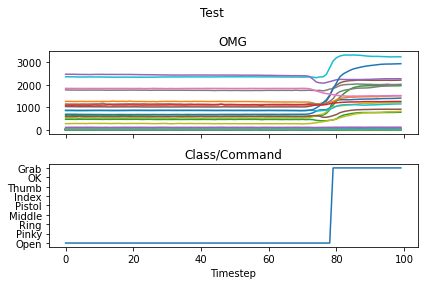

In [333]:
i = np.random.randint(df_y_test.shape[0])
fig, axx = plt.subplots(2, 1, sharex=True)
    
axx[0].plot(data_test[i].T)
axx[0].set_title('OMG')

axx[1].plot(df_y_test[i])

axx[1].set_title('Class/Command')
axx[1].set_xlabel('Timestep')
axx[1].set_yticks(
    np.arange(9),
    ['Open', 'Pinky', 'Ring', 'Middle', 'Pistol', 'Index', 'Thumb', 'OK', 'Grab']
)

plt.suptitle(f'Test')

plt.tight_layout()

## Качество предсказаний - говно

In [341]:
submition = pd.DataFrame(y_test_pred, columns=['class'])
submition.to_csv('sample_submission.csv')